In [2]:
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import metrics

import evopipe
import steps
import warnings

from sklearn.model_selection import train_test_split
from sklearn import datasets

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
wine = datasets.load_wine()
train_X, test_X, train_Y, test_Y = train_test_split(wine.data, wine.target, test_size = 0.25, random_state = 0)

params = steps.get_params(len(train_X[0]))

In [3]:
print("Format:")
print("------------")
print("Classifier")
print("score")
print("cross-validation score")
print("GridSearch score")
print("------------")
print()

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for name, cls in steps.clfs.items():
        classif = cls()
        print(classif.__class__.__name__)
        classif.fit(train_X, train_Y)
        print(classif.score(test_X, test_Y))
        print(model_selection.cross_val_score(classif, test_X, test_Y).mean())
        
        pipe_params = params[name]
        gs = model_selection.GridSearchCV(classif, params,n_jobs=-1, pre_dispatch='2*n_jobs', verbose=5)
        gs.fit(train_X, train_Y)
        
        print(gs.best_params_)
        print(gs.score(test_X, test_Y))
        print()

Format:
------------
Classifier
score
cross-validation score
GridSearch score
------------

SVC
0.5111111111111111
0.4680555555555556


ValueError: Parameter values for parameter (PCA) need to be a sequence(but not a string) or np.ndarray.

In [4]:
scorer = metrics.make_scorer(metrics.cohen_kappa_score, weights='quadratic')
clf = evopipe.EvoPipeClassifier(steps.preproc, steps.clfs, params, mutpb=0.5, swap_mutpb=0.2, param_mutpb=0.7,
                                ind_mutpb=0.8, scorer=scorer)
clf.fit(train_X, train_Y, test_X, test_Y)

score = clf.score(test_X, test_Y)
print("\nBest pipeline test score: {}\n".format(score))

best_pipes = clf.best_pipelines()

for pipe, score in best_pipes:
    pipe.fit(train_X, train_Y)
    # score = pipe.score(test_X, test_Y)
    
    pipe_named_steps = []
    for key, val in pipe.steps:
        pipe_named_steps.append(key)       
    print("Score: {}, Pipe: {}".format(score, pipe_named_steps))

Evolution starting...

Gen 6:

Hall of fame:
[('kBest', OrderedDict([('k', 6)])), ('gaussianNB', OrderedDict())]
[('kBest', OrderedDict([('k', 9)])), ('QDA', OrderedDict([('reg_param', 0.5), ('tol', 0.01)]))]
[('QDA', OrderedDict([('reg_param', 0.5), ('tol', 0.01)]))]
[('PCA', OrderedDict([('n_components', 6), ('whiten', True)])), ('SVC', OrderedDict([('C', 0.5), ('gamma', 'auto'), ('tol', 0.01)]))]
[('kBest', OrderedDict([('k', 6)])), ('QDA', OrderedDict([('reg_param', 0.5), ('tol', 0.01)]))]

Gen 11:

Hall of fame:
[('kBest', OrderedDict([('k', 6)])), ('gaussianNB', OrderedDict())]
[('gaussianNB', OrderedDict())]
[('kBest', OrderedDict([('k', 9)])), ('QDA', OrderedDict([('reg_param', 0.5), ('tol', 0.01)]))]
[('QDA', OrderedDict([('reg_param', 0.5), ('tol', 0.01)]))]
[('PCA', OrderedDict([('n_components', 6), ('whiten', True)])), ('SVC', OrderedDict([('C', 0.5), ('gamma', 'auto'), ('tol', 0.01)]))]

Gen 16:

Hall of fame:
[('kBest', OrderedDict([('k', 13)])), ('kBest', OrderedDict([('

   	                        fitness                         	                       train_test                       
   	--------------------------------------------------------	--------------------------------------------------------
gen	var        	avg     	min     	max     	var        	avg     	min     	max     
0  	0.135442   	0.61554 	-0.04884	0.982188	0.0360667  	0.784848	0.466667	1       
1  	0.00345389 	0.947773	0.76026 	0.983511	0.00153855 	0.965926	0.822222	1       
2  	0.00172959 	0.963792	0.76026 	0.983511	0.00105844 	0.971111	0.822222	1       
3  	0.0110202  	0.909259	0.687213	0.97606 	0.00748916 	0.932593	0.755556	1       
4  	8.22711e-05	0.970291	0.941956	0.983511	9.65706e-05	0.979259	0.955556	1       
5  	2.84882e-05	0.974709	0.965644	0.983511	0.000208505	0.97037 	0.955556	1       
6  	0.0590919  	0.909203	0       	0.983511	0.0161756  	0.940741	0.466667	1       
7  	7.06424e-06	0.976273	0.969688	0.983511	0.000294102	0.983704	0.933333	1       
8  	1.64109e-05	0.976007	0

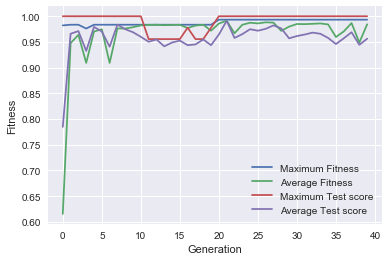

In [5]:
print(clf.logbook)

gen = clf.logbook.select("gen")
avgs, mins, maxs, vars = clf.logbook.chapters["fitness"].select("avg", "min", "max", "var")
avgs_tt, mins_tt, maxs_tt, vars_tt = clf.logbook.chapters["train_test"].select("avg", "min", "max", "var")

sns.set()

fig = plt.figure()
ax1 = fig.add_subplot(111)
line1 = ax1.plot(gen, maxs, label='Maximum Fitness')
ax1.set_xlabel("Generation")
ax1.set_ylabel("Fitness")

line2 = ax1.plot(gen, avgs, label='Average Fitness')

line3 = ax1.plot(gen, maxs_tt, label='Maximum Test score')
line4 = ax1.plot(gen, avgs_tt, label='Average Test score')

lines = line1 + line2 + line3 + line4
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc="best")

plt.show()